# Import and Setup

In [33]:
import pandas as pd
import numpy as np
import json
import os
import re
from tqdm import tqdm
import pickle
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style='whitegrid')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.svm import OneClassSVM
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from imblearn.over_sampling import RandomOverSampler, SMOTE

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub

# Load the Universal Sentence Encoder module
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.load(module_url)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
TRAIN_PATH = r"train_for_student.json"
TEST_PATH = r"test_for_student.json"

TRAIN_PATH = os.path.join(os.path.pardir, "data", TRAIN_PATH)
TEST_PATH = os.path.join(os.path.pardir, "data", TEST_PATH)

LABEL_LIST = ['CE','ENV','BME','PE','METAL','ME','EE','CPE','OPTIC','NANO','CHE','MATENG','AGRI','EDU','IE','SAFETY','MATH','MATSCI']

# Preprocess

In [8]:
def clean_and_tokenize(df, is_test=False):
    df = df.copy()

    df['Text'] = df['Title'] + " " + df['Abstract']

    df.drop(columns=['Title', 'Abstract'], inplace=True)

    # lower case
    # df['Text'] = df['Text'].apply(lambda x: x.lower())

    # remove special characters
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

    # remove text
    target_text = ['published under licence by iop publishing ltd', 'using', 'ieee', 'association for computing machinery', 'elsevier', 'springer', 'wal']
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in target_text]))

    # stemmer
    lemmatizer = WordNetLemmatizer()
    df['Text'] = df['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

    # tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [word for word in word_tokenize(x)  if word not in stop_words])

    # word cloud
    all_words = [word for tokens in df['Text'] for word in tokens]
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Top words after clean and tokenize')
    plt.axis('off')
    plt.show()

    return df

def sentences_2_vec(df):
    df = df.copy()

    eb = embed(df['Text'].apply(lambda x: ' '.join(x)))
    df['Text'] = eb.numpy().tolist()

    return df

def get_data(X, y, label, test_size=0.1, random_state=42, umsampling = True):
    X = np.array([np.array(x) for x in X['Text']])
    y = y.copy()[label]
    if test_size == 0:
        X_train, X_val, y_train, y_val = X, X, y, y
    else:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # oversampling
    if umsampling:
        ros = RandomOverSampler(random_state=random_state)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    return X_train, X_val, y_train, y_val

def load_data(path, has_label=True, vectorize=True):
    # load df
    data = json.load(open(path))

    # make df
    df = pd.DataFrame(data).transpose()

    # create labels
    if has_label:
        for idx, label in enumerate(LABEL_LIST):
            df[label] = df['Classes'].apply(lambda x: 1 if label in x else 0)
        df.drop(columns=['Classes'], inplace=True)

    # create X, y
    df = clean_and_tokenize(df, not has_label)
    if has_label:
        X = df.drop(columns=LABEL_LIST)
        if vectorize:
            X = sentences_2_vec(X)
        y = df[LABEL_LIST]
        return X, y
    else:
        if vectorize:
            df = sentences_2_vec(df)
        return np.array([np.array(x) for x in df['Text']])


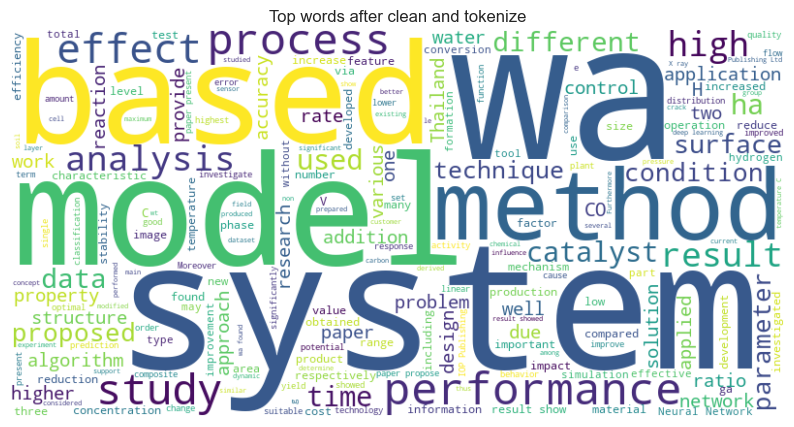

In [9]:
X_embedded, y = load_data(TRAIN_PATH, vectorize=True)

# Model

In [58]:
def score_model(model, X_train=X_embedded, y_train=y, n_cv=None, **params):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if n_cv is None:
        cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    else:
        cv = StratifiedKFold(n_splits=n_cv, random_state=42, shuffle=True)

    smoter = RandomOverSampler(random_state=42)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model
        model_obj.fit(X_train_fold_upsample, y_train_fold_upsample)

        # Score the model on the (non-upsampled) validation data
        score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)

    return np.array(scores)

In [76]:
def get_best_model_param(label):

    X_train = np.array([np.array(x) for x in X_embedded.copy()['Text']])
    y_train = y.copy()[label]

    def objective(trial):
    
        model = VotingClassifier(estimators=[
            ('lr', LogisticRegression(C=trial.suggest_float('lr_C', 1e-3, 5, log=True),
                                      class_weight='balanced')),
            ('svc', SVC(C=trial.suggest_float('svc_C', 1e-3, 5, log=True),
                        class_weight='balanced',
                        kernel='linear')),
            ('nb', GaussianNB()),
        ], )

        return np.mean(sorted(score_model(model, X_train, y_train, n_cv=5, scoring='f1'))[1:-1])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    model_param = study.best_params

    return model_param

In [77]:
abnormal_label = []

model_by_label = {}
f1_list = []
for idx, label in enumerate(LABEL_LIST):
    # get data
    X_train, _, y_train, _ = get_data(X_embedded, y, label, umsampling=False, test_size=0)


    best_model_param = get_best_model_param(label)
    model = VotingClassifier(estimators=[
        ('lr', LogisticRegression(C=best_model_param['lr_C'],
                                  class_weight='balanced')),
        ('svc', SVC(C=best_model_param['svc_C'],
                    class_weight='balanced',
                    kernel='linear')),
        ('nb', GaussianNB()),
    ])

    # evaluate
    f1 = np.mean(sorted(score_model(model, X_train, y_train, cv=5, scoring='f1'))[1:-1])
    f1_list.append(f1)

    # print
    print(f"Label: {label}({idx+1}/{len(LABEL_LIST)})")
    print(f"\tData shape: {X_train.shape}")
    print(f"\t1's class amount : {y_train.sum()}({y[label].sum() / len(y[label])*100:.2f}%)")
    print(f"\tModel: {model.__class__.__name__}")
    print(f"\tParams: {best_model_param}")
    print(f"\tf1-score: {f1.mean():.4f}")

    # save model
    model.fit(X_train, y_train)
    model_by_label[label] = model

f1_list = np.array(f1_list)
avg_f1 = f1_list.mean()
std_f1 = f1_list.std()
estimated_f1 = avg_f1 - 2 * std_f1

print(f"Average f1-score: {avg_f1 / len(LABEL_LIST)}")
print(f"Estimated f1-score: {estimated_f1 / len(LABEL_LIST)}")

# save models
with open("models.pkl", "wb") as f:
    pickle.dump(model_by_label, f)
print("Models saved")

  0%|          | 0/50 [00:00<?, ?it/s]

Label: CE(1/18)
	Data shape: (454, 512)
	1's class amount : 52(11.45%)
	Model: VotingClassifier
	Params: {'lr_C': 0.863597966922837, 'svc_C': 4.6791187420635625}
	f1-score: 0.5215


  0%|          | 0/50 [00:00<?, ?it/s]

Label: ENV(2/18)
	Data shape: (454, 512)
	1's class amount : 59(13.00%)
	Model: VotingClassifier
	Params: {'lr_C': 3.113436749718509, 'svc_C': 2.968850932391744}
	f1-score: 0.5552


  0%|          | 0/50 [00:00<?, ?it/s]

Label: BME(3/18)
	Data shape: (454, 512)
	1's class amount : 36(7.93%)
	Model: VotingClassifier
	Params: {'lr_C': 0.05880922259233673, 'svc_C': 0.056349082060214745}
	f1-score: 0.5956


  0%|          | 0/50 [00:00<?, ?it/s]

Label: PE(4/18)
	Data shape: (454, 512)
	1's class amount : 86(18.94%)
	Model: VotingClassifier
	Params: {'lr_C': 2.4637587499649825, 'svc_C': 2.410798914056889}
	f1-score: 0.6518


  0%|          | 0/50 [00:00<?, ?it/s]

Label: METAL(5/18)
	Data shape: (454, 512)
	1's class amount : 72(15.86%)
	Model: VotingClassifier
	Params: {'lr_C': 4.7435622569855695, 'svc_C': 1.1717811684627384}
	f1-score: 0.6387


  0%|          | 0/50 [00:00<?, ?it/s]

Label: ME(6/18)
	Data shape: (454, 512)
	1's class amount : 90(19.82%)
	Model: VotingClassifier
	Params: {'lr_C': 0.0010036380703178371, 'svc_C': 0.2625195324625677}
	f1-score: 0.4535


  0%|          | 0/50 [00:00<?, ?it/s]

Label: EE(7/18)
	Data shape: (454, 512)
	1's class amount : 118(25.99%)
	Model: VotingClassifier
	Params: {'lr_C': 0.4834468775446538, 'svc_C': 2.06275875680627}
	f1-score: 0.7110


  0%|          | 0/50 [00:00<?, ?it/s]

Label: CPE(8/18)
	Data shape: (454, 512)
	1's class amount : 142(31.28%)
	Model: VotingClassifier
	Params: {'lr_C': 0.44975660218479957, 'svc_C': 0.35967950760428474}
	f1-score: 0.7222


  0%|          | 0/50 [00:00<?, ?it/s]

Label: OPTIC(9/18)
	Data shape: (454, 512)
	1's class amount : 31(6.83%)
	Model: VotingClassifier
	Params: {'lr_C': 0.035922240849543464, 'svc_C': 3.4969376848236378}
	f1-score: 0.4175


  0%|          | 0/50 [00:00<?, ?it/s]

Label: NANO(10/18)
	Data shape: (454, 512)
	1's class amount : 32(7.05%)
	Model: VotingClassifier
	Params: {'lr_C': 1.784829997859026, 'svc_C': 4.453271437918362}
	f1-score: 0.5549


  0%|          | 0/50 [00:00<?, ?it/s]

Label: CHE(11/18)
	Data shape: (454, 512)
	1's class amount : 177(38.99%)
	Model: VotingClassifier
	Params: {'lr_C': 3.0152386002202056, 'svc_C': 0.5290672030144051}
	f1-score: 0.8952


  0%|          | 0/50 [00:00<?, ?it/s]

Label: MATENG(12/18)
	Data shape: (454, 512)
	1's class amount : 64(14.10%)
	Model: VotingClassifier
	Params: {'lr_C': 0.8769190231875126, 'svc_C': 1.9670539732426078}
	f1-score: 0.5911


  0%|          | 0/50 [00:00<?, ?it/s]

Label: AGRI(13/18)
	Data shape: (454, 512)
	1's class amount : 20(4.41%)
	Model: VotingClassifier
	Params: {'lr_C': 0.05144070630535353, 'svc_C': 0.23029566705776897}
	f1-score: 0.5212


  0%|          | 0/50 [00:00<?, ?it/s]

Label: EDU(14/18)
	Data shape: (454, 512)
	1's class amount : 32(7.05%)
	Model: VotingClassifier
	Params: {'lr_C': 0.7567621249933278, 'svc_C': 2.371255064153978}
	f1-score: 0.4131


  0%|          | 0/50 [00:00<?, ?it/s]

Label: IE(15/18)
	Data shape: (454, 512)
	1's class amount : 74(16.30%)
	Model: VotingClassifier
	Params: {'lr_C': 4.956332644948331, 'svc_C': 0.26895865711686456}
	f1-score: 0.5391


  0%|          | 0/50 [00:00<?, ?it/s]

Label: SAFETY(16/18)
	Data shape: (454, 512)
	1's class amount : 22(4.85%)
	Model: VotingClassifier
	Params: {'lr_C': 0.3869096433435767, 'svc_C': 0.15903577996777324}
	f1-score: 0.2868


  0%|          | 0/50 [00:00<?, ?it/s]

Label: MATH(17/18)
	Data shape: (454, 512)
	1's class amount : 112(24.67%)
	Model: VotingClassifier
	Params: {'lr_C': 0.4820625189236425, 'svc_C': 0.5212460305494789}
	f1-score: 0.6494


  0%|          | 0/50 [00:00<?, ?it/s]

Label: MATSCI(18/18)
	Data shape: (454, 512)
	1's class amount : 119(26.21%)
	Model: VotingClassifier
	Params: {'lr_C': 4.848256012362265, 'svc_C': 2.876530643904368}
	f1-score: 0.6930
Average f1-score: 0.5783768238001044
Models saved


# Submission

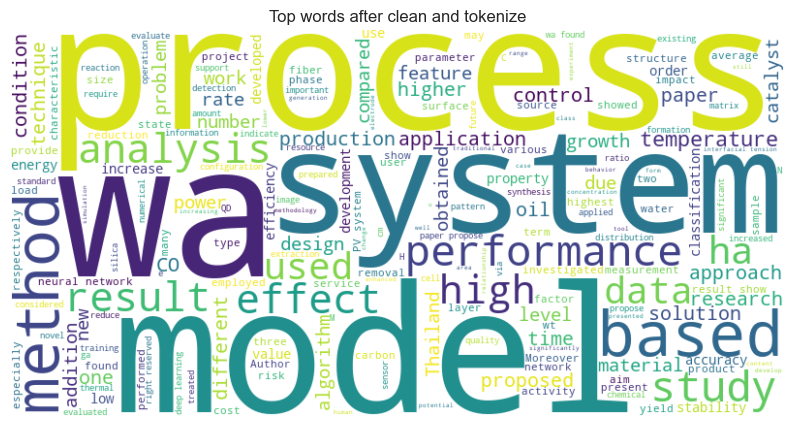

In [78]:
X_test = load_data(TEST_PATH, has_label=False)

In [79]:
X_test.shape

(151, 512)

In [80]:
submission_df = pd.DataFrame(columns= LABEL_LIST,
                             index= [f"{'0'*(3-len(str(k+1)))}{k+1}eval" for k in range(151)])

for label in LABEL_LIST:
    model = model_by_label[label]
    submission_df[label] = model.predict(X_test)

submission_df.index.name = "id"
submission_df

,CE,ENV,BME,PE,METAL,ME,EE,CPE,OPTIC,NANO,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI
id,,,,,,,,,,,,,,,,,,
001eval,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0
002eval,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,0,1
003eval,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
004eval,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0
005eval,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147eval,0,1,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1
148eval,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
149eval,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1


In [81]:
submission_df.to_csv("submission.csv")

In [82]:
!kaggle competitions submit -c 2110446-data-science-2023-02 -f submission.csv -m "USE embeded + voting(tuned) + Stemming" 

100%|██████████████████████████████████████| 6.57k/6.57k [00:01<00:00, 3.67kB/s]
Successfully submitted to 2110446 Data Science and Data Engineering Tools